In [2]:
from traitlets.config.manager import BaseJSONConfigManager
import jupyter_core
path = "/Users/i.oseledets/anaconda2/envs/teaching/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager()
cm.update("livereveal", {
              "theme": "sky",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "scroll": True
})

{'scroll': True,
 'start_slideshow_at': 'selected',
 'theme': 'sky',
 'transition': 'zoom'}

# Lecture 10:  Sparse direct solvers & Iterative methods

## Recap of the previous lecture
- Sparse matrix formats (COO, CSR, CSC)
- Matrix-by-vector product

## Today lecture

1. Sparse direct solvers: nested dissection and spectral clustering in details
2. Concept of **iterative methods** for linear systems: 
    - Richardson iteration and its convergence
    - Chebyshev iteration

## Fill-in

The fill-in of a matrix are those entries which **change from an initial zero to a nonzero** value during the execution of an algorithm.

## Gaussian elimination for sparse matrices

Given matrix $A=A^*>0$ we calculate its Cholesky decomposition $A = LL^*$.

Factor $L$ can be dense even if $A$ is sparse:

$$
\begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix} = 
\begin{bmatrix} * &  &  &  \\ * & * &  &  \\ * & * & * &  \\ * & * & * & * \end{bmatrix}
\begin{bmatrix} * & * & * & * \\  & * & * & * \\  &  & * & * \\  &  &  & * \end{bmatrix}
$$

How to make factors sparse, i.e. to minimize the **fill-in**?

## Gaussian elimination and permutation

We need to find a permutation of indices so that factors are sparse, i.e. we build Cholesky factorisation of $PAP^\top$, where $P$ is a permutation matrix.

For the example from the previous slide

$$
P \begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix} P^\top = 
\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\ * & * & * & * \end{bmatrix} = 
\begin{bmatrix} * &  &  &  \\  & * &  &  \\  &  & * &  \\ * & * & * & * \end{bmatrix}
\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\  & &  & * \end{bmatrix}
$$

where
$$
P = \begin{bmatrix}  &  &  & 1 \\  &  & 1 &  \\  & 1 &  &  \\ 1 &  &  &  \end{bmatrix}
$$

How to choose the appropriate permutation for a general sparse matrix?

The idea is to use graph interpretation.

## Sparse matrices and graph

Sparse matrix can be treated as an **adjacency matrix** of a certain graph:

- The vertices $(i, j)$ are connected, if the corresponding matrix element is non-zero.

- If the matrix is symmetric the graph can be undirected, otherwise it is directed.

### Example

Graphs of $\begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix}$ and $\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\ * & * & * & * \end{bmatrix}$ have the following form:

<img src="./pics/graph_dense.png", width=300, align="center"> and <img src="./pics/graph_sparse.png", width=300, align="center">

## Nested dissection

The **nested dissection** algorithm for choosing the order is based on the **divide-and-conquer** paradigm.

**Definition:** A **separator** in a graph $G$ is a set $S$ of vertices whose removal leaves at
least two connected components.

A nested dissection ordering for an $N$-vertex graph $G$ enumerates its
vertices from $1$ to $N$ as follows:
- Find a separator $S$, whose removal leaves connected components
$T_1$, $T_2$, $\ldots$, $T_k$
- Number the vertices of $S$ from $N − |S| + 1$ to $N$
- Recursively, number the vertices of each component: $T_1$ from $1$ to
$|T_1|$, $T_2$ from $|T_1| + 1$ to $|T_1| + |T_2|$, etc
- If a component is small enough, enumeration in this component is arbitrarily

It all boils down to finding good separators! 

From theory, nested dissection gives you optimal complexity. 

## Nested dissection and rectangular grid

Separator for the 2D Laplacian matrix 

$$
 A_{2D} = I \otimes A_{1D} + A_{1D} \otimes I, \quad A_{1D} = \mathrm{tridiag}(-1, 2, -1),
$$

is as follows

<img src='pics/grid_separator.png'> </img>

Once we have enumerated first indices in $\alpha$, then in $\beta$ and then in $\sigma$ we get the following matrix

$$
PAP^\top = \begin{bmatrix} A_{\alpha\alpha} &  & A_{\alpha\sigma} \\  & A_{\beta\beta} & A_{\beta\sigma} \\ A_{\sigma\alpha} & A_{\sigma\beta} & A_{\sigma\sigma}\end{bmatrix}
$$

For blocks $A_{\alpha\alpha}$, $A_{\beta\beta}$ we continue splitting recursively.

When the recursion is done, we need to eliminate blocks $A_{\sigma\alpha}$ and $A_{\sigma\beta}$. 

This makes block in the position of $A_{\sigma\sigma}\in\mathbb{R}^{n\times n}$ dense.

Calculation of Cholesky of this block costs $\mathcal{O}(n^3) = \mathcal{O}(N^{3/2})$, where $N = n^2$ is the total number of nodes.

So, the complexity is $\mathcal{O}(N^{3/2})$

### Nested dissection summary

- Enumeration: find a separator, proceed recursively.
- In theory, optimal.
- In practice, beats others only for very large problems.

## Separators in practice

Computing separators is not a **trivial task**.

Graph partitioning heuristics has been an active research area for many years, often motivated by partitioning for parallel computation.

Existing approaches:

- Spectral partitioning (uses eigenvectors of Laplacian matrix of graph)
- Geometric partitioning (for meshes with specified vertex coordinates)
- Iterative-swapping (Kernighan-Lin, Fiduccia-Matheysses)
- Breadth-first search 
- Flow/LP-based techniques
- Multilevel recursive bisection (heuristic, currently most practical)

We consider spectral partitioning in details

## Spectral graph partitioning

The idea of spectral partitioning goes back to Fiedler.

We need to split the vertices into two sets.

Consider +1/-1 labeling of vertices and **the cost**

$$E_c = \sum_{j} \sum_{i \in N(j)} (x_i - x_j)^2, \quad N(j) \text{ denotes set of neighbours of a node } j. $$

We need a balanced partition, thus 
$$\sum_i x_i =  0 \quad \Longleftrightarrow \quad x^\top e = 0, \quad e = \begin{bmatrix}1 & \dots & 1\end{bmatrix}^\top,$$
and since we have +1/-1 labels, we have
$$\sum_i x^2_i = n \quad \Longleftrightarrow \quad \|x\|_2^2 = n.$$

## Graph Laplacian

Cost $E_c$ can be written as (check why)

$$E_c = (Lx, x)$$

where $L$ is the **graph Laplacian**, which is defined as a symmetric matrix with

$$L_{ii} = \mbox{degree of node $i$},$$

$$L_{ij} = -1, \quad \mbox{if $i \ne j$  and there is an edge},$$

and $0$ otherwise.

- Rows of $L$ sum to zero, thus there is an eigenvalue $0$ and gives trivial eigenvector of all ones.
- Eigenvalues are non-negative (why?).

## Partitioning as an optimization problem

Minimization of $E_c$ with the mentioned constraints leads to a partitioning that tries to minimize number of edges in a separator, while keeping the partition balanced. 

We now relax the integer quadratic programming to the continuous quadratic programming

$$E_c = (Lx, x)\to \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}}$$

## Fiedler vector
The solution to the minimization problem is given by the eigenvector (called Fiedler vector) corresponding  to the second smallest eigenvalue of the graph Laplacian. 
Indeed,

$$
    \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}} (Lx, x) = n \cdot \min_{{x^\top e =0}} \frac{(Lx, x)}{(x, x)} = n \cdot \min_{{x^\top e =0}} R(x), \quad R(x) \text{ is the Rayleigh quotient}
$$
Since $e$ is the eigenvector, corresponding to the smallest eigenvalue, on the space $x^\top e =0$ we get the second minimal eigevalue.

The sign $x_i$ indicates the partitioning.

In computations, we need to find out, how to find this second minimal eigenvalue –– we at least know about power method, but it finds the largest.
We will discuss iterative methods for eigenvalue problems later in our course.

This is the main goal of the iterative methods for large-scale linear problems, and
can be achieved via few matrix-by-vector products.

# A few words about the other ordering selection algorithms

## Banded reordering

Make the matrix more "banded" (Reverse Cuhill-McKee, Sloan, etc.). 

The idea is to try keeping entries closer to the diagonal. 

## Minimal degree orderings

The idea is to eliminate rows and/or columns with fewer non-zeros, update fill-in and then repeat

Efficient implementation is an issue (adding/removing elements).

Current champion is "approximate minimal degree" by Amestoy, Davis, Duff.

It is **suboptimal** even for 2D problems

In practice, it often wins for medium-sized problems.

# Iterative methods

If we want to achieve $\mathcal{O}(N)$ complexity, then direct solvers are not appropriate.

If we want to solve partial eigenproblem, the full eigendecomposition is too costly.

For both problems we will use iterative, Krylov subspace solvers, which treat the matrix as a **black-box** linear operator.

## Matrix as a black box

We have now an absolutely different view on a matrix: matrix is now a **linear operator**, that acts on a vector,  
and this action can be computed in $\mathcal{O}(N)$ operations.

**This is the only information** we know about the matrix: the <font color='red'> matrix-by-vector product (matvec) </font>

Can we solve linear systems using only matvecs?

Of course, we can multiply by the colums of the identity matrix, and recover the full matrix, but it is not what we need.

## Richardson iteration
The simplest idea is the **"simple iteration method"** or **Richardson iteration**.  


  $$Ax = f,$$
  $$\tau  (Ax - f) = 0,$$
   $$x - \tau (Ax - f) = x,$$
   $$x_{k+1} = x_k - \tau (Ax_k - f),$$
   
   where $\tau$ is the **iteration parameter**, which can be always chosen such that the method **converges**.

## Connection to ODEs

The Richardson iteration has a deep connection to the Ordinary Differential Equations (ODE).


Consider a time-dependent problem ($A=A^*>0$)

$$\frac{dy}{dt} + A y = f, \quad y(0) = y_0.$$

Then $y(t) \rightarrow A^{-1} f$ as $t \rightarrow \infty$, and the **Euler scheme** reads

$$\frac{(y_{k+1} - y_k)}{\tau} = -A y_k + f.$$

which leads to the Richardson iteration
$$
    y_{k+1} = y_k - \tau(Ay_k -f)
$$

## Convergence of the Richardson method
Let $x_*$ be the solution; introduce an error $e_k = x_{k} - x_*$, then  

$$
     e_{k+1} = (I - \tau A) e_k,
$$

therefore if $\Vert I - \tau A \Vert < 1$ in any norm, the iteration converges. 

For symmetric positive definite case it is always possible to select $\tau$ such that the method converges.

What about the non-symmetric case?

## Optimal parameter choice
The choise of $\tau$ that minimizes $\|I - \tau A\|_2$ for $A = A^* > 0$ is (prove it!)
$$
  \tau_\mathrm{opt} = \frac{2}{\lambda_{\min} + \lambda_{\max}}.
$$

where $\lambda_{\min}$ is the minimal eigenvalue, and $\lambda_{\max}$ is the maximal eigenvalue of the matrix $A$.

So, to find optimal parameter, we need to know the **bounds of the spectrum** of the matrix $A$,
and we can compute it by using **power method**.

## Condition number and convergence speed

Even with the optimal parameter choice, the error at the next step satisfies

$$e_{k+1} \leq q e_k , \quad\rightarrow \quad e_k \leq q^{k} e_0,$$

where 

$$
   q = \frac{\lambda_{\max} - \lambda_{\min}}{\lambda_{\max} + \lambda_{\min}} = \frac{\mathrm{cond}(A) - 1}{\mathrm{cond}(A)+1},
$$

$$\mathrm{cond}(A) = \frac{\lambda_{\max}}{\lambda_{\min}} \quad \text{for} \quad A=A^*>0$$

is the condition number of $A$.

Let us do some demo...

((-0.081014052771004735+0j), (-3.9189859472289981+0j))

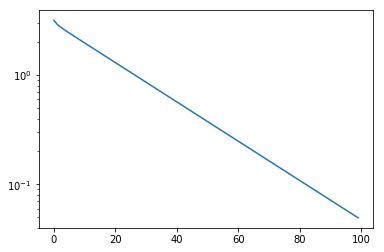

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix
n = 10
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigs(lp1, k=2, which='LR')
ev2, vec = spla.eigs(lp1, k=2, which='SR')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = 2.0/(lam_max + lam_min)

fig, ax = plt.subplots()
plt.close(fig)

niters = 100
x = np.zeros(n)
res_all = []
for i in range(niters):
    rr = lp1.dot(x) - rhs
    x = x - tau_opt * rr
    res_all.append(np.linalg.norm(rr))
#Convergence of an ordinary Richardson (with optimal parameter)
plt.semilogy(res_all)
lam_max, lam_min

Thus, for **ill-conditioned** matrices the error of the simple iteration method decays very slowly.<br>
This is another reason why **condition number** is so important:

* Besides  the bound on the error in the solution, it also gives an estimate of the number of iterations for the iterative methods.

Main questions for the iterative method is how to make the matrix **better conditioned**. <br>
The answer is <font color='red'> use preconditioners </font>. Preconditioners will be discussed in further lectures.

## Better iterative methods

But before preconditioners, we can use **better iterative methods**. 

There is a whole **zoo** of iterative methods, but we need to know just few of them.

## Attempt 1: The steepest descent method

Suppose we **change** $\tau$ every step, i.e. 
$$
   x_{k+1} = x_k - \tau_k (A x_k - f).
$$
A possible choice of $\tau_k$ is such that it minimizes norm of the current residual (was considered in the pset 1). <br> 
This method is called **the steepest descent**.

However, it still converges similarly to the Richardson iteration.

## Attempt 2: Chebyshev iteration

Another way to find $\tau_k$ is to consider
$$e_{k+1} = (I - \tau_k A) e_k = (I - \tau_k A) (I - \tau_{k-1} A)  e_{k-1} = \ldots = p(A) e_0, $$

where $p(A)$ is a **matrix polynomial** (simplest matrix function)  

$$
   p(A) = (I - \tau_k A) \ldots (I - \tau_0 A),
$$

and $p(0) = 1$.

## Optimal choice of time steps
The error is written as 

$$e_{k+1} = p(A) e_0, $$
and hence
$$\|e_{k+1}\| \leq \|p(A)\| \|e_0\|, $$
where $p(0) = 1$ and $p(A)$ is a **matrix polynomial**. 

To get better **error reduction**, we need to minimize

$$\Vert p(A) \Vert$$ over all possible polynomials $p(x)$ of degree $k+1$ such that $p(0)=1$. We will use $\|\cdot\|_2$.

##  Polynomials least deviating from zeros

Important special case: $A = A^* > 0$.

Then $A = U \Lambda U^*$, 

and 



$$\Vert p(A) \Vert_2 = \Vert U p(\Lambda) U^* \Vert_2 = \Vert p(\Lambda) \Vert_2 = \max_i |p(\lambda_i)| \overset{!}{\leq}
\max_{\lambda_\min \leq \lambda {\leq} \lambda_\max} |p(\lambda)|.$$

The latter inequality is the only approximation. Here we make a <font color='red'> crucial assumption </font> that we do not want to benefit from distribution of spectra between $\lambda_\min$ and $\lambda_\max$.

Thus, we need to find a polynomial such that $p(0) = 1$, that has the least possible deviation from $0$ on $[\lambda_\min, \lambda_\max]$.

##  Polynomials least deviating from zeros (2)

We can do the affine transformation of the interval $[\lambda_\min, \lambda_\max]$ to the interval $[-1, 1]$:

$$
\xi = \frac{{\lambda_\max + \lambda_\min - (\lambda_\max - \lambda_\min)x}}{2}, \quad x\in [-1, 1].
$$

The problem is then reduced to the problem of finding the **polynomial least deviating from zero** on an interval $[-1, 1]$ 

with some normalization constraint $p(0) = 1$.


## Exact solution: Chebyshev polynomials

The exact solution to this problem is given by the famous **Chebyshev polynomials** of the form

$$T_n(x) =  \cos (n \arccos x)$$

## What do you need to know about Chebyshev polynomials

1. This is a polynomial! (we can express $T_n$ from $T_{n-1}$ and $T_{n-2}$: $T_n(x) = 2x T_{n-1}(x) - T_{n-2}(x)$, $T_0(x)=1$, $T_1(x)=x$).

2. $|T_n(x)| \leq 1$ on $x \in [-1, 1]$.

3. It has $(n+1)$ **alternation points**, were the the maximal absolute value is achieved (this is the sufficient and necessary condition for the **optimality**) (Chebyshev alternance theorem, no proof here).

4. The **roots** are just  
$$n \arccos x_k = \frac{\pi}{2} + \pi k, \quad \rightarrow\quad x_k = \cos \frac{\pi(2k + 1)}{2n}$$

We can plot them...

Text(0.5,1,'Interval $x\\in[-1.1, 1.1]$')

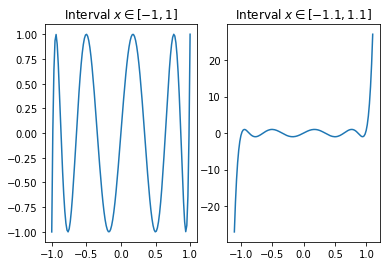

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x1 = np.linspace(-1, 1, 128)
x2 = np.linspace(-1.1, 1.1, 128)
p = np.polynomial.Chebyshev((0, 0, 0, 0, 0, 0, 0, 0, 0, 1), (-1, 1)) #These are Chebyshev series, a proto of "chebfun system" in MATLAB
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x1, p(x1))
ax1.set_title('Interval $x\in[-1, 1]$')
ax2.plot(x2, p(x2))
ax2.set_title('Interval $x\in[-1.1, 1.1]$')

## Convergence of the Chebyshev-accelerated Richardson iteration

Note that $p(x) = (1-\tau_k x)\dots (1-\tau_0 x)$, hence roots of $p(x)$ are $1/\tau_i$ and that we additionally need to map back from $[-1,1]$ to $[\lambda_\min, \lambda_\max]$.
This results into 

$$\tau_i = \frac{2}{\lambda_\max + \lambda_\min - (\lambda_\max - \lambda_\min)x_i}, \quad x_i = \cos \frac{\pi(2i + 1)}{2n}\quad i=1,\dots,k$$

The convergence (we only give the result without the proof) is now given by

$$
   e_{k+1} \leq C q^k e_0, \quad q = \frac{\sqrt{\mathrm{cond}(A)}-1}{\sqrt{\mathrm{cond}(A)}+1},
$$
which is better than in the Richardson iteration.

## Beyond Chebyshev

We have made an important assumption about the spectrum: it is contained within an interval over the real line (and we need to know the bounds)

If the spectrum is contained within **two intervals**, and we know the bounds, we can also put the optimization problem 

for the **optimal polynomial**.



## Spectrum of the matrix contained in multiple segments

For the case of **two segments** the best polynomial is given by **Zolotarev polynomials** (expressed in terms of elliptic functions)

For the case of **more than two segments** the best polynomial can be expressed in terms of **hyperelliptic functions**

## How can we make it better

The implementation of the Chebyshev acceleration requires the knowledge of the spectrum.

It only stores the **previous vector** $x_k$ and computes the new correction vector

$$r_k = A x_k - f.$$

It belongs to the class of **two-term** iterative methods, i.e. it approximates $x_{k+1}$ using 2 vectors: $x_k$ and $r_k$.

It appears that if we **store more vectors**, then we can go without the spectrum estimation (and better convergence in practice)!

## Crucial point: Krylov subspace

The Chebyshev method produces the approximation of the form

$$x_{k+1} = p(A) r_0,$$

i.e. it lies in the **Krylov subspace** of the matrix  which is defined as

$$
   \mathcal{K}_k(A, r_0) = \mathrm{Span}(r_0, Ar_0, A^2 r_0, \ldots, A^{k-1}r_0 )
$$

The most natural approach then is to find the vector in this **linear subspace** that minimizes 
certain **norm of the error**

## Idea of Krylov methods

The idea is to minimize given functional:
- Energy norm of error for systems with hermitian positive-definite matrices (CG method).
- Residual norm for systems with general matrices (minres and GMRES methods).
- Rayleigh quotient for eigenvalue problems (Lanczos method).

To make methods practical one has to 
1. Orthogonalize vectors $A^i r_0$ of the Krylov subspace for stability (Lanczos process).
2. Derive recurrent formulas to decrease complexity.

We will consider these methods in details on the next lecture.

## Take home message

- Finalized Gaussian elimination for sparse matrices and its connection to graphs
- Introduced two iterative methods: Richardson iteration and Chebyshev acceleration

## Next lecture

- Several Krylov iterative methods: conjugate gradient (CG), GMRES.
- Lanczos and Arnoldi orthogonalization of Krylov subspaces, optimality result for Krylov subspaces
- Convergence estimates

# Questions?

In [16]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()